In [115]:
import os
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
# from vis_utils import *
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random 
import math

In [116]:
data_train_src = datasets.FashionMNIST(root=dataset_dir, train=True, download=True, transform=trans)
data_test_src = datasets.FashionMNIST(root=dataset_dir, train=False, download=True, transform=trans)

In [117]:
data_train_loader = DataLoader(data_train_src, batch_size=4)

In [118]:
for X,y in data_train_loader:
    break

TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [119]:
data_train.data.shape

torch.Size([60000, 28, 28])

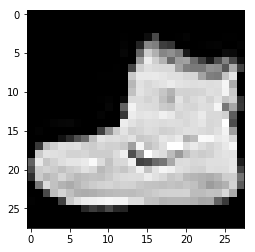

In [120]:
plt.imshow(data_train.data[0], cmap=plt.cm.gray)

### Hyperparameters

In [138]:
num_epochs = 25
batch_size = 100
learning_rate = 0.001

### Data loading

In [122]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        '''
        csv_file (string): Path to csv file
        transform (callable): Optional transform to apply to sample
        '''
        
        # Load data into dataframe and convert to numpy for indexing
        data = pd.read_csv(csv_file)
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28) 
        self.Y = np.array(data.iloc[:, 0])
        
        del data
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    # Return a single img and its label from loader
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        
        # Transform inputs before returning
        if self.transform:
            item = self.transform(item)
            
        return item, label

#### Get data readers

In [123]:
train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv')
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

#### Define data loaders

In [124]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                     batch_size=batch_size,
                                     shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

#### Iterate over loader the loader, get items in batch to process on

Also use data reader to visualize some images and see the dataset.

In [125]:
labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt', 
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

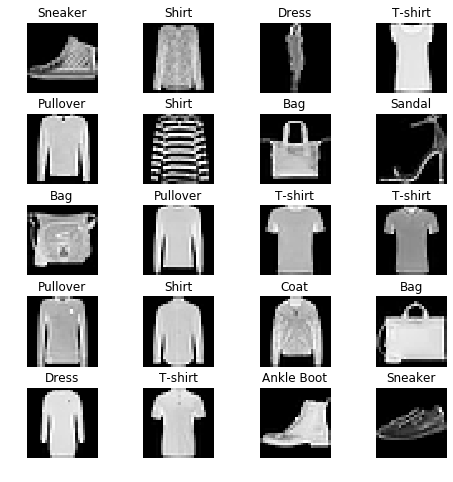

In [126]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=None, hspace=0.3)
columns = 4
rows = 5

for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

### The neural network

Implement the neural network graph, which is easier and more intuitive in PyTorch than Keras and TensorFlow.

In PyTorch, the neural networks are inherited from the ```nn.Module``` class and define the graph in the constructor. 

In [127]:
class CNN(nn.Module):
    def __init__(self):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # Conv layer: nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
            nn.Conv2d(1, 16, kernel_size=5, padding=2),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # After 2 conv layers & activations, end network with Fully Connected layer 
        # that outputs to 10 classes
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
        out = self.layer1(x)
        out = self.layer2(out)
        
        # Reshape output to match dims required for final layer
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        
        return out
        

### Training the model

After defining the neural network graph, declare the loss function to optimize, and start training model.

In [128]:
# Instantiate an instance of the conv net
cnn = CNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

#### Train!

Iterate over a batch of images in ```train_loader```. For each batch: <br>
- Zero out gradients in the optimizer. Bc ```backward()``` acccumulates gradients, we should not mix values bw mini batches.
- Feed data through cnn. This calls ```forward()``` and gets its output.
- Calculate the loss based on outputs and actual labels.
- Backprop the gradients. 
- Update parameters based on the back propagated values

In [ ]:
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Add loss values to array to print out progress of training
        losses.append(loss.data) 
        
        if (i+1) % 100 == 0:
            batch = len(train_dataset)//batch_size
            print(f'Epoch: {epoch+1}/{num_epochs}, Iter: {i+1}/{batch}, Loss: {loss.data:.3f}')
            
            

Epoch: 1/25, Iter: 100/600, Loss: 0.111
Epoch: 1/25, Iter: 200/600, Loss: 0.308
Epoch: 1/25, Iter: 300/600, Loss: 0.161
Epoch: 1/25, Iter: 400/600, Loss: 0.256
Epoch: 1/25, Iter: 500/600, Loss: 0.278
Epoch: 1/25, Iter: 600/600, Loss: 0.282
Epoch: 2/25, Iter: 100/600, Loss: 0.162
Epoch: 2/25, Iter: 200/600, Loss: 0.163
Epoch: 2/25, Iter: 300/600, Loss: 0.138
Epoch: 2/25, Iter: 400/600, Loss: 0.149
Epoch: 2/25, Iter: 500/600, Loss: 0.145
Epoch: 2/25, Iter: 600/600, Loss: 0.130
Epoch: 3/25, Iter: 100/600, Loss: 0.204
Epoch: 3/25, Iter: 200/600, Loss: 0.176
Epoch: 3/25, Iter: 300/600, Loss: 0.139
Epoch: 3/25, Iter: 400/600, Loss: 0.215
Epoch: 3/25, Iter: 500/600, Loss: 0.109
Epoch: 3/25, Iter: 600/600, Loss: 0.231
Epoch: 4/25, Iter: 100/600, Loss: 0.095
Epoch: 4/25, Iter: 200/600, Loss: 0.135
Epoch: 4/25, Iter: 300/600, Loss: 0.151
Epoch: 4/25, Iter: 400/600, Loss: 0.160
Epoch: 4/25, Iter: 500/600, Loss: 0.117
Epoch: 4/25, Iter: 600/600, Loss: 0.193
Epoch: 5/25, Iter: 100/600, Loss: 0.107


### Evaluate the model on test set

In [ ]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max()